In [62]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('D:\iith\python_scripts\Randam_Features.csv')

# Split the dataset into features (X) and the target (y)
X = data.drop(columns=["Sequence_ID", "Sequence", "Anti_aging","Unnamed: 0", 'Length', 'Molecular_formula'])
y = data['Anti_aging']


# Feature selection to reduce dimensionality (select top 50 features)
selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X, y)

# Optional: Apply PCA for further dimensionality reduction (e.g., 20 components)
pca = PCA(n_components=20)
X_reduced = pca.fit_transform(X_selected)

# Train-test split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

## Standardizing the features
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

# Initializing the XGBoost model
xgb_model = XGBClassifier(
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss', 
    n_estimators=100,  # Default value, optimized through grid search
    max_depth=3,  # Reduced complexity
    learning_rate=0.05,  # Balanced learning rate
    subsample=0.8,  # Use subset of data to prevent overfitting
    colsample_bytree=0.8,  # Use subset of features to prevent overfitting
    reg_alpha=1,  # L1 regularization to reduce complexity
    reg_lambda=5  # L2 regularization to reduce complexity
)

# Setting up the parameter grid for randomized search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],  # Added smaller subsample to reduce overfitting
    'colsample_bytree': [0.6, 0.8, 1.0],  # Added smaller values
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 5, 10]
}

# Using RandomizedSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',  # Change this to suitable metric for regression tasks
    cv=2,
    verbose=1,
    n_jobs=-1
)

print(X_reduced)


[[ -4.68601867  -1.47279452  -8.79492549 ...  -0.39811234   0.20574648
   -1.01956823]
 [ -9.66563092  -8.00151076  40.95467826 ...   0.85417634   0.3431781
    0.1978681 ]
 [ -8.00136111  18.24303739 -13.50814494 ...   0.30628103   1.69318763
    0.14836686]
 ...
 [ -8.07268892  -7.15520906  -0.60019366 ...   0.09623658  -0.76072521
   -0.39763606]
 [ -1.68550854 -15.29038714   6.87552435 ...  -0.11990007  -1.20555918
   -0.84159405]
 [-14.35617896   6.0774954    0.23141418 ...   0.23532246  -0.87207958
   -0.52747748]]


<>:15: SyntaxWarning: invalid escape sequence '\i'
<>:15: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Aryan\AppData\Local\Temp\ipykernel_3336\2093728657.py:15: SyntaxWarning: invalid escape sequence '\i'
  data = pd.read_csv('D:\iith\python_scripts\Randam_Features.csv')


In [64]:
# Performing the random search
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

Fitting 2 folds for each of 6561 candidates, totalling 13122 fits
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 0.6}
Best Cross-Validation Accuracy: 0.7883956176905498


d:\iith\python_scripts\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:32:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [65]:

#predicting on test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model on the training set
test_accuracy_1 = accuracy_score(y_test, y_pred)
test_precision_1 = precision_score(y_test, y_pred, average='binary', pos_label=1)
test_recall_1 = recall_score(y_test, y_pred, average='binary', pos_label=1)
test_f1_1 = f1_score(y_test, y_pred, average='binary', pos_label=1)
test_mcc_1 = matthews_corrcoef(y_test, y_pred)

# Calculate specificity for the training set
conf_matrix = confusion_matrix(y_test, y_pred)
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
specificity_1 = TN / (TN + FP)


#predicting on the train set itself
y_train_pred = grid_search.best_estimator_.predict(X_train)

# Evaluate the model on the training set
train_accuracy_1 = accuracy_score(y_train, y_train_pred)
train_precision_1 = precision_score(y_train, y_train_pred, average='binary', pos_label=1)
train_recall_1 = recall_score(y_train, y_train_pred, average='binary', pos_label=1)
train_f1_1 = f1_score(y_train, y_train_pred, average='binary', pos_label=1)
train_mcc_1 = matthews_corrcoef(y_train, y_train_pred)

# Calculate specificity for the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
train_TN = train_conf_matrix[0, 0]
train_FP = train_conf_matrix[0, 1]
train_specificity_1 = train_TN / (train_TN + train_FP)

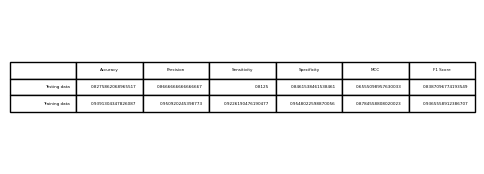

In [66]:
data_1 = {
   '' : ['Testing data', 'Training data'],
   'Accuracy' : [test_accuracy_1, train_accuracy_1],
   'Precision' : [test_precision_1, train_precision_1],
   'Sensitivity' : [test_recall_1, train_recall_1],
   'Specificity' : [specificity_1, train_specificity_1],
   'MCC' : [test_mcc_1, train_mcc_1],
   'F1 Score' : [test_f1_1, train_f1_1]
}

df = pd.DataFrame(data_1)

fig, ax = plt.subplots(figsize=(6, 2))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')

# Create a table
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')

# Save as PNG
plt.savefig("xgb_results_hpt.png", bbox_inches='tight', dpi=300)
plt.show()

In [50]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for whole X
scores = cross_val_score(grid_search.best_estimator_, X, y, cv=cv, scoring='f1')

print("Cross-validation scores:", scores)
print("Mean f1 score without RFE:", scores.mean())

d:\iith\python_scripts\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\iith\python_scripts\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\iith\python_scripts\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:11:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\iith\python_scripts\venv\Lib\si

Cross-validation scores: [0.82608696 0.73809524 0.75949367 0.85714286 0.7816092 ]
Mean f1 score without RFE: 0.7924855836096418
